<!--# STAT 207: Data Science Exploration-->
## Analysis of Variance

In the general linear regression framework we saw that we can test individual regression coefficients in the model for statistical significance using the coefficient t-tests. This approach is most useful when one of the effects, such as a treatment effect, is of primary interest, and other variables are included as covariate adjustments. There is a danger, however, in doing multiple tests when we have more than one varable in the model. By doing so we can inflate the false positive rate, increasing the chance of detecting nonexistent results purely by increasing the number of tests performed.

Analysis of variance (ANOVA) gives us a way to counteract this effect, by testing all effects simultaneously to see if *any* variable is significant. It also lies behind the interpretation of $R^2$ as the proportion of variance explained by the model.

The strategy is to compare the full model with a constrained, null, model in which the set of parameters we wish to test are zeroed out or constrained. The change in residual sum of squares forms the basis for constructing an F test for the null hypothesis that the constrained model is correct.

As special cases we consider:

- F test for the regression

- Oneway ANOVA when the explanatory variable is categorical, i.e., the $k$ sample design

- Testing a subset of variables in multiple linear regression

Relevant libraries and functions:

- pandas.DataFrame.groupby
- statsmodels.api
- statsmodels.formula.api
- statsmodels.formula.api.ols
- statsmodels.regression.linear_model
- RegressionResults.compare_f_test



### Example: Geographic analysis of melanoma mortality

Mortality rates from skin cancer are available from the CDC. Early studies of the relation between exposure to sunlight and melanoma, a type of skin cancer investigated the relation between mortality from skin cancer and geographic location in degrees latitude (how far north or south); Elwood et al. (1974). In this study, each state is represented by the latitude of its largest city. Mortality rates are age-standardized and expressed in rates per 1 million population.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

#### Import and explore the data

In [2]:
skin = pd.read_csv("../data/skin.txt", 
                   delim_whitespace=True)
display(skin.shape, skin.head())

(49, 4)

,state,latitude,mortality,ocean
0,AL,33.0,219,1
1,AZ,34.5,160,0
2,AR,35.0,170,0
3,CA,37.5,182,1
4,CO,39.0,149,0


Check if any missing values using the pandas notna() and all() functions. notna() returns True if a value is not missing and False if missing. all() returns True only if all elements n a column are True. It returns False if any element is False.

In [3]:
skin.notna().all()

state        True
latitude     True
mortality    True
ocean        True
dtype: bool

Looks clean.

Let's view a scatter plot of mortality versus latitude. How can we also incorporate 'ocean', a binary indicator variable in the plot? One way is to color each state's data point by whether or not it is an ocean state. In the seaborn scatterplot function the 'style' and 'hue' arguments do this.

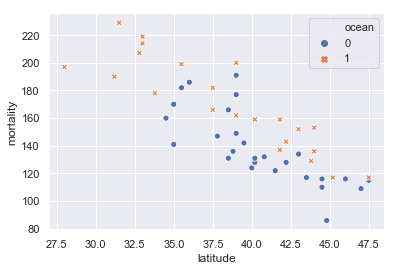

In [4]:
sns.scatterplot(x='latitude', y='mortality', 
                style='ocean', 
                hue='ocean', 
                data=skin)
plt.show()

#### Fit a multiple regression model

Let's fit a regression model that includes latitude, the ocean coastal indicator, and a possible interaction between these two variables. Mathematically, this model has the form:

$$
\mbox{Expected Mortality Rate} = \beta_0 + \beta_1 * \mbox{latitude} + \beta_2 * \mbox{ocean}
+ \beta_3 * \mbox{latitude} * \mbox{ocean}
$$

The interaction is expressed as the product of 'latitude' and the 0-1 value for 'ocean'. How can we interpret this? It creates two regression lines, one for ocean=0 (the reference line), and one for ocean=1:

$$
\begin{align}
\mbox{ocean=0:}&\qquad \mbox{Expected Mortality Rate} = \beta_0 + \beta_1 * \mbox{latitude} \\
\mbox{ocean=1:}&\qquad \mbox{Expected Mortality Rate} = (\beta_0 + \beta_2) + (\beta_1 + \beta_3) * \mbox{latitude} \\
\end{align}
$$

The interaction term in the model means that the dependence of the mortality rate on latitude is modified by whether or not the state touches the ocean. By fitting the model we can test the difference coefficients.

In the python statsmodels formula package, the interaction is included as 'latitude:ocean'.

In [5]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [6]:
# create the fitted model object
mod1 = smf.ols('mortality ~ latitude + ocean + latitude*ocean', 
               data=skin).fit()

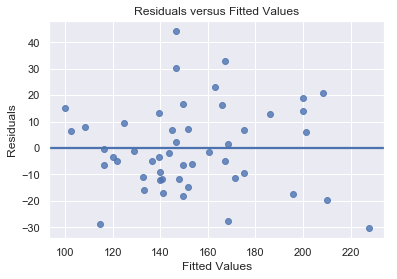

In [7]:
# residual plot for inital check on the model fit
sns.regplot(x=mod1.fittedvalues, y=mod1.resid, ci=None)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals versus Fitted Values')
plt.show()

Now let's have a look at the model summary.

In [8]:
mod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              mortality   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     50.11
Date:                Mon, 30 Mar 2020   Prob (F-statistic):           2.17e-14
Time:                        10:27:53   Log-Likelihood:                -205.02
No. Observations:                  49   AIC:                             418.0
Df Residuals:                      45   BIC:                             425.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        360.5495     35.498     10.157      0.000     289.052     432.047
latitude          -5.4853      0.874     -6.274      0.000      -7.246      -3.724
ocean             20.6501     43.988      0.469      0.641     -67.946     109.246
latitude:ocean    -0.0055      1.101     -0.005      0.996      -2.224       2.213
==============================================================================
Omnibus:                        2.149   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.342   Jarque-Bera (JB):                1.576
Skew:                           0.437   Prob(JB):                        0.455
Kurtosis:                       3.085   Cond. No.                     1.00e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  1e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Form of the fitted model

Based on the results in the summary, we see that the estimated model has the form:

$$
\text{mortality} = 360.55 - 5.49*\text{latitude} + 20.65*\text{ocean} -0.0055*\text{latitude}*\text{ocean}.
$$

In order to interpret the results, it is important to be able to extract the form of the model from the summary tables.

#### Coefficient t tests

The coefficient t tests indicate that latitude is highly statistically signficant with p < 0.001. Neither ocean nor the latitude x ocean interaction appears to be significant based on their coeffiicent t tests.

#### Question

We can see individual t test statistics for each of the three varaibles in the model, and these give individual tests. How can we test all three coefficents at the same time and control the false positive rate?

### F test for regression

Considering the preceding example, with three regression variables in the model, how can we perform a test of the following hyptheses?

$$
H_0: \beta_1=\beta_2=\beta_3=0\qquad \mbox{versus} \qquad H_A: \mbox{at least one of } \beta_1, \beta_2, \beta_3 \ne 0
$$

The key is to compare the residual sum of square with and without these variables in the model. As in the preceding section, let's use the general notation:


| $X_1$ | $X_2$ | $X_3$ | $Y$ |
| --- | --- | --- | --- | 
| $x_{11}$ | $x_{12}$ | $x_{13}$ | $y_1$ |
| $x_{21}$ | $x_{22}$ | $x_{23}$ | $y_2$ |
| $\vdots$ | $\vdots$ | $\vdots$ | $\vdots$ |
| $x_{n1}$ | $x_{n2}$ | $x_{n3}$ | $y_n$ |

We compare the full three variable model with the null model without *any* explanatry variables. The null model still includes the intercept if the full model does. The fitted values, residual sums of squares, and *degrees of freedom (df)* for these models are as follows:

$$
\begin{align}
\mbox{Full model:}&\qquad
\hat{y}_i = \hat{\beta}_0 +  \hat{\beta}_1 x_{i1} + \hat{\beta}_2 x_{i2} + \hat{\beta}_3 x_{i3} 
&RSS = \sum_{i=1}^n (y_i - \hat{y}_i)^2\\
& &df = n-3-1=n-4\\
\\
\mbox{Null model:}&\qquad
\hat{y}_{0i} = \bar{y} 
&RSS_0 = \sum_{i=1}^n (y_i - \bar{y})^2\\
& &df = n-1 \qquad\\
\end{align}
$$

here $RSS$ refers to the **residual sum of squares**, and ${RSS}_0$ refers to the residual sum of squares for the null model, sometimes called the **total sum of squares** for the response.

The sum of squares accounted for by the regression is the difference, which has $df_{diff} = (n-1) - (n-3-1) = 3$ degrees of freedom in this case:

$$
SSReg = RSS_0 - RSS = \sum_{i=1}^n (\hat{y}_i - \bar{y})^2
$$

where the second equality of this last equation can be shown using the normal equations solved by the least squares estimates.

The regression sum of squares is $\ge 0$ because the null model is the special case of the full model where the explantory coefficients equal 0. Consequently, the minimized sum of square residuals cannot be smaller for the null model than for the full model. (The more options you add, the smaller the minimum can be).

Assuming the full model is correctly specified, i.e. that there are no missing variables, and assuming Gaussian noise terms in the model, the following statistic is a ratio of independent chi-square statistics divided by their degrees of freedom:

$$
F = {SSReg / p \over RSS / (n-p-1)}
$$

It provides a test of the null model $H_0$ versus versus the full model expressed by $H_A$.

A random variable with this representation is said to have an **F distribution with p and n-p-1 degrees of freedom**. in the context of our example, n=49, p=3, so the F test statistic has degrees of freedom 3 and 49-3-1 = 45.

Given F for our model, we can compute the p-value using the **scipy.stats.f** function in python.

It is also worth observing at this point that the denominator of the F test statistic provides an unbiased estimator of the full model error variance:

$$
\hat{\sigma}^2 = {RSS\over n-p-1}.
$$

### Relation between R-squared and F

Both F and $R^2$ depend on $RSS$ and $RSS_0$. They can be related to each other as follows. First, recall that

$$
R^2 = {RSS_0 - RSS \over RSS_0}
$$

Therefore $F$ can be rewritten in terms of $R_2$ as

$$
\begin{align}
F = {(RSS_0 - RSS)/ p \over RSS / (n-p-1)} &=
\left({RSS_0 \over RSS}\right) \left({RSS_0 - RSS \over RSS_0}\right) \left({n-p-1 \over p}\right)\\
\\
&= \left({n-p-1 \over p}\right) \left({R^2 \over 1 - R^2}\right)\\
\end{align}
$$

In other words, the higher the "proportion of variance explained" ($R^2$), the larger the value for $F$ and vice versa, for a given model and sample size.

### F test for Model: Geographic analysis of melanoma mortality

The F value appears in the first tabe of the model summary underneath the R-squared statistic. The table also displays the p-value "Prob(F-statistic)" and degrees of freedom for the model and residuals.

In [9]:
mod1.summary().tables[0]

Dep. Variable:,mortality,R-squared:,0.770
Model:,OLS,Adj. R-squared:,0.754
Method:,Least Squares,F-statistic:,50.11
Date:,"Mon, 30 Mar 2020",Prob (F-statistic):,2.17e-14
Time:,10:27:53,Log-Likelihood:,-205.02
No. Observations:,49,AIC:,418.0
Df Residuals:,45,BIC:,425.6
Df Model:,3,,
Covariance Type:,nonrobust,,


We see that F= 50.11 with degrees of freedom 3 and 45. The p-value is essentially zero, so there is no question the model is signficant. At least one of the explanatory variables is needed in the model.

Let's confirm the p-value by direct calculation.

In [10]:
import numpy as np
from scipy.stats import f 

In [11]:
pvalue= 1 - f.cdf(50.11, dfn=3, dfd=45)
pvalue

2.1649348980190553e-14

**Nondirectional nature of F test**

Notice that we only use the right hand tail in this calculation. This is because the F test is already a nondirectional test of deviations from the null hypothesis, and we reject $H_0$ for large values only, no for small values.

Graph of the F distribution and cutoff for hypothetical level $\alpha$ test of $H_0$.

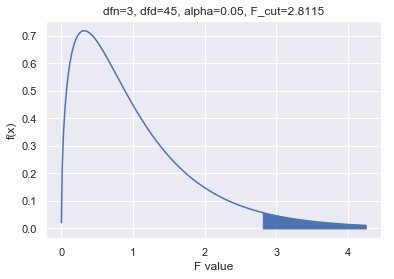

In [12]:
alpha = 0.05
Fvalue = 9.87
dfn, dfd = 3, 45
# alpha cutoff value
Fcut = f.ppf(1-alpha, dfn, dfd)
# set up for probability density curve
x = np.linspace(0.0001, f.ppf(0.99, dfn, dfd), 400)
plt.plot(x, f.pdf(x, dfn, dfd))
plt.xlabel('F value')
plt.ylabel('f(x)')
# Construct the title based on input data
degn = 'dfn=' + str(dfn)
degd = 'dfd=' + str(dfd)
alph = 'alpha=' + str(alpha)
fcut = 'F_cut=' + str(round(Fcut, 4))
comma = ', '
plt.title(degn+comma+degd+comma+alph+comma+fcut)
# add shaded areas whose probability we need
xfval = np.linspace(Fcut, f.ppf(0.99, dfn, dfd), 100)
plt.fill_between(xfval, 0, f.pdf(xfval, dfn, dfd), color='b')
plt.show()

### F test for One-Way ANOVA Model

A very common special case of linear regression models is when there is one categorical explanatory variable, and the goal is to determine if the **mean response** is significantly different between categories of the explanatory variable. 

This is an extension of two-sample analysis where we have one categorical exaplanatory variable, such as website version A versus B, and we compare them based on a quantitifed outcome. The ANOVA approach lets us compare K > 2 categories at the same time.


### Example: Comparison of mean age across party affilations in the Pew Reseach Survey

#### Import and clean data

In [13]:
import zipfile as zp
zf = zp.ZipFile('../data/Feb17-public.zip')
missing_values = ["NaN", "nan", "Don't know/Refused (VOL.)"]
pew = pd.read_csv(zf.open('Feb17public.csv'), 
                   na_values=missing_values)[['age', 'party']].dropna()
pew.head()

,age,party
0,80.0,Independent
1,70.0,Democrat
2,69.0,Independent
3,50.0,Republican
4,70.0,Democrat


In [14]:
pew['party'].value_counts()

Democrat                527
Independent             525
Republican              367
No preference (VOL.)     41
Other party (VOL.)        5
Name: party, dtype: int64

Let's rename the party categories so they are easier to label in graphs. We can do this as follows.

In [15]:
# rename categories so they display better
party = pd.Categorical(pew['party'])
party.rename_categories({'Democrat': 'Dem', 
                         'Independent': 'Ind', 
                         'Republican': 'Rep',
                         'No preference (VOL.)': 'No_Pref',
                         'Other party (VOL.)': 'Other'
                        }, inplace=True)
pew['party']=party

In [16]:
pew['party'].value_counts()

Dem        527
Ind        525
Rep        367
No_Pref     41
Other        5
Name: party, dtype: int64

#### Visualize the data

With several groups we can use side by side boxplots to visualize the age distributions.

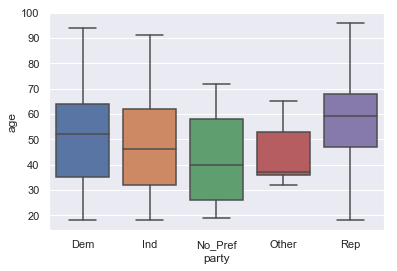

In [17]:
sns.boxplot(x='party', y='age', data=pew)
plt.show()

#### Using Pandas GroupBy function to get summary stats within groups

In [18]:
# within group means
pew.groupby('party').mean()

,age
party,
Dem,50.499051
Ind,46.807619
No_Pref,43.146341
Other,44.600000
Rep,56.776567


In [19]:
# within group sample standard deviations
pew.groupby('party').std()

,age
party,
Dem,17.687279
Ind,17.517144
No_Pref,17.062475
Other,13.939153
Rep,16.885801


In [20]:
# within group sample sizes
pew.groupby('party').count()

,age
party,
Dem,527
Ind,525
No_Pref,41
Other,5
Rep,367


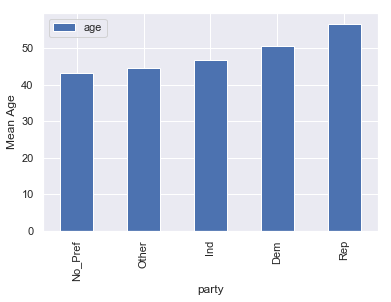

In [21]:
pew.groupby('party').mean().sort_values(by='age').plot.bar()
plt.ylabel('Mean Age')
plt.show()

#### Fit a one-way anova regression model

Are there significant mean age differences between the different self-reported party affiliations? We can fit a one-way anova model with 5 categories of 'party'. The ols function will encode the categorical party affiliatoin variable into a series of 0/1 indicator variables. One category will be the reference category. Sometimes this is called  reference cell coding.

In [22]:
agemod = smf.ols('age ~ party', data=pew).fit()
agemod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    age   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     19.82
Date:                Mon, 30 Mar 2020   Prob (F-statistic):           6.66e-16
Time:                        10:27:55   Log-Likelihood:                -6261.1
No. Observations:                1465   AIC:                         1.253e+04
Df Residuals:                    1460   BIC:                         1.256e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           50.4991      0.758     66.618      0.000      49.012      51.986
party[T.Ind]        -3.6914      1.073     -3.440      0.001      -5.796      -1.587
party[T.No_Pref]    -7.3527      2.821     -2.606      0.009     -12.887      -1.818
party[T.Other]      -5.8991      7.819     -0.754      0.451     -21.237       9.439
party[T.Rep]         6.2775      1.183      5.306      0.000       3.957       8.598
==============================================================================
Omnibus:                      130.613   Durbin-Watson:                   1.725
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.798
Skew:                          -0.017   Prob(JB):                     1.38e-09
Kurtosis:                       2.183   Cond. No.                         19.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Interpretation of the model: equivalence of reference cell and cell means models

Notice that the 'Intercept' in the model above equals the sample mean age for Democrats. In this case Democrats are the reference category. The other coefficients are incremental adjustments for other parties versus Democrats. 

**Example: Coding of Republicans and non Republicans.**

$$
\text{party[T.Rep]} = \cases{1,& if 'party'$\,=\,$'Rep'\\ 0,& if 'party'$\,\ne\,$ 'Rep'\\}
$$

The effective model for Republicans is that the mean age is

$$
50.4991 + 6.2775 = 56.7766.
$$

This is equal to the sample mean age for Republicans.

In [23]:
# Check calculation
50.4991 + 6.2775

56.7766

The same relation holds for all the other groups. In other words, for the $k$ group model, the fitted value for each observation is equal to the sample mean for the group that individual is from. 

**Coding of all groups**

Overall the numerical coding of the binary X variables for different groups is as follows:

| Party | party[T.Ind] | party[T.No_Pref] | party[T.Other] | party[T.Rep] |
| --- | --- | --- | --- | --- |
| Dem | 0 | 0 | 0 | 0 |
| Ind | 1 | 0 | 0 | 0 |
| No_Pref | 0 | 1 | 0 | 0 |
| Other | 0 | 0 | 1 | 0 |
| Rep | 0 | 0 | 0 | 1 |


#### F test for regression = test for equality of mean ages across parties

The F test is highly significant (F = 19.82, p < 0.001), so we conclude there are significant differences in mean age across the self-reported party affiliations.

The null hypothesis for this test is that the population mean ages for the different parties are all the same:

$$
H_0:\quad \mu_{Dem} = \mu_{Ind} = \cdots \mu_{Rep}.
$$

Rejecting this hypothesis implies that there is at least one pair of groups whose population mean values are deemed to be significantly different from each other.

**Comments:**


+ In the linear model results we can see that 4 0/1 indicator variables were generated for each party versus the reference party (Democrats). The F test for the regression is a test of the party differences, with 4 and 1460 degrees of freedom. The coefficient estimates are mean age adjustments for each party versus the mean for Democrats.

+ A key assumption for validity of the F test here is that the response variable (age) has the same variance within each group. The box plot above suggests this is a reasonable assumption in the IQR, a measure of spread is similar in each group.


### Simple Linear Regression: Relation between F test for model and t test for slope

The simplest regression model is when there is only one explanatory varible. In this case, we can work out explicit expressions for the least squares estimates and standard errors. Also, in this case, it turns out that the F test for the regression is equivalent to the two-sided t test for the regression coefficient.

In [24]:
brain = pd.read_csv('../data/brain.csv') 
brain.head(10)

,species,bodykg,braing
0,African elephant,6654.000,5712.0
1,African giant pouched rat,1.000,6.6
2,Arctic Fox,3.385,44.5
3,Arctic ground squirrel,0.920,5.7
4,Asian elephant,2547.000,4603.0
5,Baboon,10.550,179.5
6,Big brown bat,0.023,0.3
7,Brazilian tapir,160.000,169.0
8,Cat,3.300,25.6
9,Chimpanzee,52.160,440.0


In [25]:
brain_mod = smf.ols('np.log10(braing) ~ np.log10(bodykg)', 
                    data=brain).fit()
brain_mod.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.9271,0.042,22.227,0.000,0.844,1.011
np.log10(bodykg),0.7517,0.028,26.409,0.000,0.695,0.809


In [26]:
brain_mod.summary().tables[0]

Dep. Variable:,np.log10(braing),R-squared:,0.921
Model:,OLS,Adj. R-squared:,0.919
Method:,Least Squares,F-statistic:,697.4
Date:,"Mon, 30 Mar 2020",Prob (F-statistic):,9.84e-35
Time:,10:27:56,Log-Likelihood:,-12.626
No. Observations:,62,AIC:,29.25
Df Residuals:,60,BIC:,33.51
Df Model:,1,,
Covariance Type:,nonrobust,,


In [27]:
print('F value: ', brain_mod.fvalue)
print('Square of t value for slope coef: ', brain_mod.tvalues[1]**2)

F value:  697.4200360590312
Square of t value for slope coef:  697.4200360590308


We see that the square root of coefficient t statistic for 'np.log10(bodykg) equals the F statistic for the regression. 

### Extension: F test for comparing two regression models

The F test for the regression is a special case of a general method for comparing two regression models, a full model and a reduced model. The F test for the model takes the reduced model to be the one that has no explanatory variables, just the intercept. The more general testing problem is to compare two **nested models**, where the smaller model is a special case of the larger model, and the null hypothesis is that the smaller model is adequate for describing the data.  




#### Example: melanoma mortality study

Here we compare two models:

**Full Model:**

$$
\mbox{Expected Mortality Rate} = \beta_0 + \beta_1 * \mbox{latitude} + \beta_2 * \mbox{ocean}
+ \beta_3 * \mbox{latitude} * \mbox{ocean}
$$

**Reduced Model:**

$$
\mbox{Expected Mortality Rate} = \beta_0 + \beta_1 * \mbox{latitude}
$$


To compare these models we consider the null hypothesis: $H_0$: $\beta_2=0$ and $\beta_3=0$ against the alternative $H_A$: $\beta_2 \ne 0$ or $\beta_3\ne 0$. The null hypothesies here is that there is no 'ocean' main effect or interaction.


Operationally we can test for the difference between the two models by fitting both models and comparing the difference in residual sums of squares using an F test. Suppose we compare two models and the reduced model is obtained by zeroing out q of the parameters. Then we can organize the computations as follows.

$$
\begin{align}
\mbox{Full Model:}&\quad  df_1=n - p -q -1 \quad &RSS_1 = \sum_{i=1}^n (y_i - \hat{y}_i)^2 & &\\
\mbox{Reduced Model:}&\quad df_0 = n-p-1 \quad &RSS_0 = \sum_{i=1}^n (y_i - \hat{y}_{0i})^2 & \\
\\
\mbox{Difference:}&\quad df_{diff} = df_0 - df_1 = q & SS_{Diff} = RSS_0 - RSS_1 \\
\end{align}
$$

Here the full model has $q$ more parameters than the reduced. We compute the F statistic as follows:

$$
F_{diff} = {SS_{diff} / (df_{diff}) \over RSS_1 / df_1 } = { (RSS_0 - RSS_1)/q \over  RSS_1 / (n-p-1) }
$$

If $H_0$ (the reduced model) is correct, then $F_{diff}$ has an F distribution with $q$ and $n-p-1$ degrees of freedom. 

In our example, n=49, p = 3, q=2, and the degrees of freedom for F are 2 and 49-3-1=45.

The statsmodels.regression.linear_model function .compare_f_test is one implementation of this test.

In [28]:
# The two fitted models we wish to compare
# mod 1 is the full model
# mod 0 is the restricted model (null hypothesis)
mod1 = smf.ols('mortality ~ latitude + ocean + latitude*ocean', 
               data=skin).fit()
mod0 = smf.ols('mortality ~ latitude', data=skin).fit()

In [29]:
import statsmodels.regression.linear_model as lm

In [30]:
f, p, df = mod1.compare_f_test(mod0)
pd.DataFrame({'f': [f], 'pvalue': [p], 'df_diff': [df]})

,f,pvalue,df_diff
0,8.769251,0.000608,2.0


We reject the null hypothesis that the  'ocean' main effect and interaction can be removed from the model. Ocean contiguity is a signficant factor.

**Interaction model versus additive model**

We can also compare the larger model to the additive model that removes the interaction between ocean and latitude.

In this case we compare:


**Full Model:**

$$
\mbox{Expected Mortality Rate} = \beta_0 + \beta_1 * \mbox{latitude} + \beta_2 * \mbox{ocean}
+ \beta_3 * \mbox{latitude} * \mbox{ocean}
$$

**Reduced Model:**

$$
\mbox{Expected Mortality Rate} = \beta_0 + \beta_1 * \mbox{latitude} + \beta_2 * \mbox{ocean}
$$

The null hypothesis here is $H_0$: $\beta_3=0$, with the alternative $H_A$: $\beta_3 \ne 0$. This same hypothesis is the target of the coefficient t-test for $\beta_3$, and we will demonstrate that for this type of 1 degree of freedom test,

$$
F_{diff} = t_{coef}^2.
$$


In [31]:
mod01 = smf.ols('mortality ~ latitude + ocean', 
                data=skin).fit()
f1, p1, df1 = mod1.compare_f_test(mod01)
pd.DataFrame({'f': [f1], 'pvalue': [p1], 'df_diff': [df1]})

,f,pvalue,df_diff
0,0.000025,0.996013,1.0


**Here we see that F is very small and the p-value is large, so we fail to reject. The simpler additive model is adequate for these data.**

In this case the F test is equivalent to the coefficient t test for the interaction ocean:latitude.

In [32]:
mod1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,360.5495,35.498,10.157,0.000,289.052,432.047
latitude,-5.4853,0.874,-6.274,0.000,-7.246,-3.724
ocean,20.6501,43.988,0.469,0.641,-67.946,109.246
latitude:ocean,-0.0055,1.101,-0.005,0.996,-2.224,2.213


In [33]:
# check using results above
t_interact = -0.005
F_interact = 0.000025
print("t squared: "+str(t_interact**2)+", F: "+ str(F_interact))

t squared: 2.5e-05, F: 2.5e-05


In [34]:
# Final model summary
mod01.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,360.6905,21.498,16.778,0.000,317.417,403.964
latitude,-5.4888,0.526,-10.437,0.000,-6.547,-4.430
ocean,20.4304,4.825,4.234,0.000,10.718,30.143


**Conclusions** 

+ In the final model we see that a parallel regressions model is adequate. It implies that the mortality rate tends to decrease by -5.5 per 1 million for each increase of 1% latitude, on average. The 95% confidence interval for this effect is (-6.547, -4.430) per million.


+ The model also implies that being near an ocean is associated with an additional 20 per million in annual mortality. The 95% confidence interval for this effect is (10.7, 30.143) per million.

Let's redo the scatter plot of the data using the final model, adding the individual regression lines to the scatter plot. We plot for mortality versus latitude separating ocean versus non-ocean. We can see that the individual regression lines computed separtely for each group are very nearly parallel.

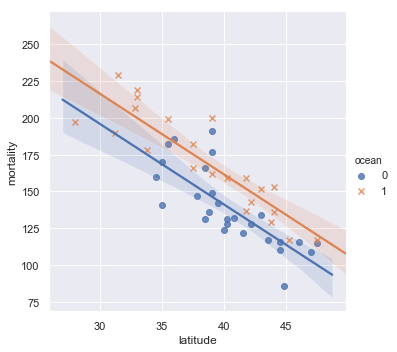

In [35]:
sns.lmplot(x="latitude", y="mortality", hue="ocean", 
           data=skin, markers=["o", "x"])
plt.show()

### What does the model predict for Illinois?

Let's extract the latitude for Illinois ad compare the model prediction with the observed rate.

In [36]:
skin[skin["state"]=="IL"]

,state,latitude,mortality,ocean
11,IL,40.0,124,0


In [37]:
mod01.predict(exog=dict(latitude=40, ocean=0))

0    141.139538
dtype: float64

In [38]:
# Compare direct calculation

360.6905 - 5.4888*40 + 20.4304*0

141.13849999999996

We see that the observed rate in Illinois was below the predicted rate by about 17 per million. Compare this with the residual standard error for the model, which is an estimate of the individual standard deviations:

In [39]:
# Extract mean square for residuals; 
# Its square root is an estimate of the sigma for 
# the random errors in the model 
rstd = np.sqrt(mod01.mse_resid)
rstd

16.38995028338583

We see that Illinois is well within 2 estimated standard deviations of the regression line, so it is consistent with the overall trend in the data.

### One-way ANOVA as a test between two models

Using the full model/reduced model framework, if we take the reduced model to be the null model with an interccept only, then we recover the F test for the regression. This gives another way to perform the F test for the one way ANOVA model.

#### Pew example revisited

We previously imported and cleaned the 'party' and 'age' fields from the Pew Research Survey, saving them in the data frame 'pew'.

We fit the full model and null model (regression on the constant '1'):

In [40]:
# Full model
agemod = smf.ols('age ~ party', data=pew).fit()
# Null model
agemod0 = smf.ols('age ~ 1', data=pew).fit()

Here are the coefficient estimates for the full model:

In [41]:
agemod.params

Intercept           50.499051
party[T.Ind]        -3.691432
party[T.No_Pref]    -7.352710
party[T.Other]      -5.899051
party[T.Rep]         6.277516
dtype: float64

In contrast, the null model has only one coefficient:

In [42]:
agemod0.params

Intercept    50.522867
dtype: float64

Having fit these nested models we can now test the null model against the unconstrained model

In [43]:
f_party, p_party, df_party = agemod.compare_f_test(agemod0)
pd.DataFrame({'f': [f_party], 
              'pvalue': [p_party], 
              'df_diff': [df_party]})

,f,pvalue,df_diff
0,19.818566,6.659457e-16,4.0


Comparing this result with F test for the regression for the uncontrained model we see that they produce the same result.

The advantage of the using compare_f_test is we explicitly control what is being tested.


#### References

Elwood JM, Lee JAH, Walter SD, Mo T, Green AES (1974). Relationship of melanoma and other skin cancer mortality to latitude and ultraviolet radiation in the United States and Canada. International Journal of Epidemiology, Vol. 3, No. 4, pp. 325-332.



---
STAT 207, Douglas Simpson, University of Illinois at Urbana-Champaign